In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns

from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr, zscore

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [5]:
# 2. set parameters
num_corpuses = 1000
num_samples_per_corpus = 1000
colours = [
    "r",
    "b",
    "g",
    "y",
    "m",
    "c",
    "lightcoral",
    "lightblue",
    "lightgreen",
    "lightyellow",
    "lightpink",
    "lightcyan",
    "gray",
]
names = [
    "k50_t1.0",
    "k50_t1.5",
    "k50_t2.0",
    "p090_t1.0",
    "p090_t1.5",
    "p090_t2.0",
    "p095_t1.0",
    "p095_t1.5",
    "p095_t2.0",
    "anc_t1.0",
]

In [12]:
# metropolis hastings on df
steps = 1000
samples = df.sample(n=steps + 1, replace=True)
acceptance_thresholds = np.random.uniform(0.0, 1.0, size=steps)
acceptances = list()
prev = samples.iloc[0]
for step in range(1, steps + 1):
    sample = samples.iloc[step]
    acceptance = (
        np.exp(
            -sample["original_negative_log_probability"]
            + prev["original_negative_log_probability"]
        )
        > acceptance_thresholds[step - 1]
    )
    if acceptance:
        prev = sample
    acceptances.append(acceptance)
acceptance_rate = np.mean(acceptances)



Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll_humanassistant_includeprompt_conditioned.csv:
Length: 1943
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------

Text(0.5, 0, 'Mean log probability')

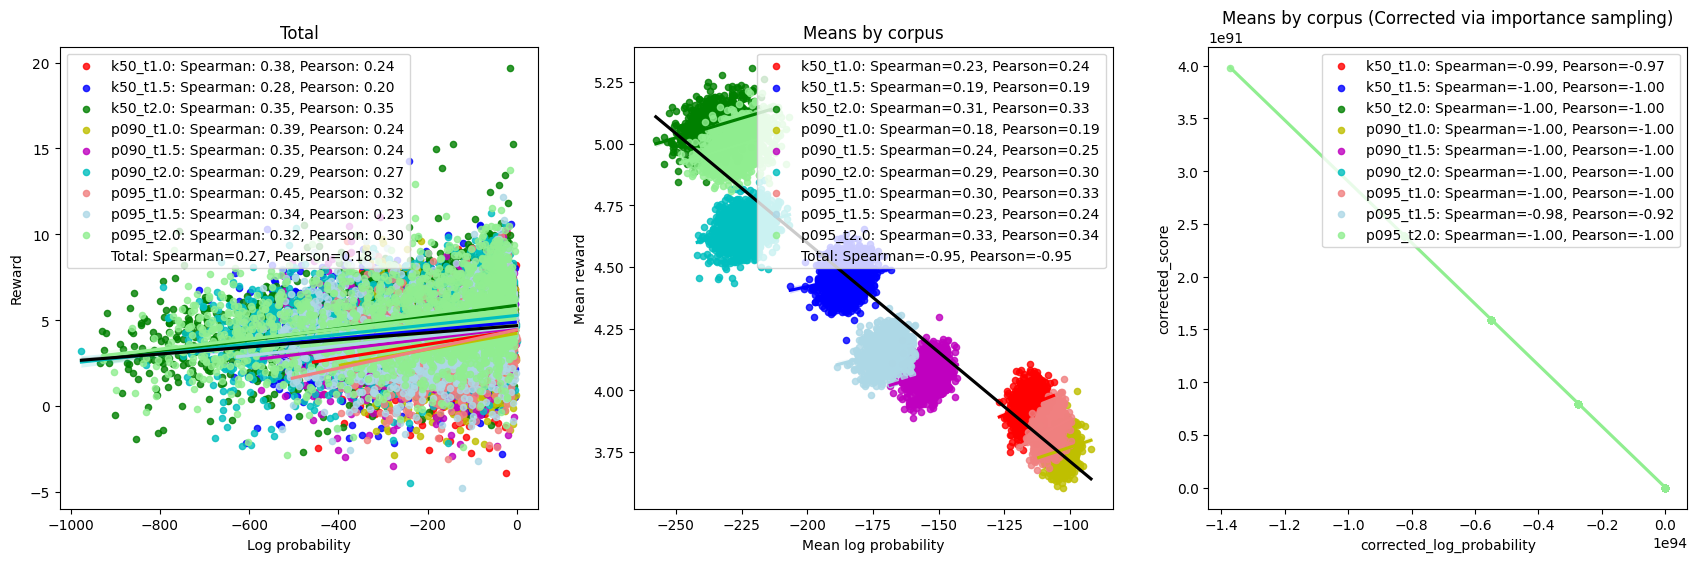

In [35]:
# 3. analysis on each corpus
# 3.0 a single output figure
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
total_mean_corpuses = None
total_corpus = None
total_mean_corrected_corpuses = None
for idx, (reward_df_file, nll_df_file, correction_df_file) in enumerate(triplet_files):
    print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")
    # 3.1 load and merge
    reward_df = pd.read_csv(f"data/{reward_df_file}")
    nll_df = pd.read_csv(f"data/{nll_df_file}")
    correction_df = pd.read_csv(f"data/{correction_df_file}")
    df = reward_df.merge(nll_df, on=["prompt", "generated_text"]).merge(
        correction_df, on=["prompt", "generated_text"]
    )

    # 3.1.1 get log probability
    df["log_probability"] = -df["negative_log_probability"]

    # 3.1.2 filter duplicates, empty strings, invalid probabilities
    df = df[
        df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)
    ].drop_duplicates()
    df = df[
        df["log_probability"].apply(
            lambda x: False if (np.isinf(x) or np.isnan(x)) else True
        )
    ]
    print(f"Length: {len(df)}")
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))
    print(
        tabulate(
            df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
        )
    )

    # 3.1.3 compute correction ratio
    df["correction_ratio"] = df.apply(
        lambda row: np.exp(
            -row["original_negative_log_probability"]
            + row["samplingbiased_negative_log_probability"]
        ),
        axis=1,
    )
    df["corrected_score"] = df.apply(
        lambda row: row["score"] * row["correction_ratio"], axis=1
    )
    df["corrected_log_probability"] = df.apply(
        lambda row: row["log_probability"] * row["correction_ratio"],
        axis=1,
    )

    # 3.1.4 outliers
    # df = df[
    #     (np.abs(zscore(df[["score", "log_probability", "correction_ratio"]])) < 3).all(
    #         axis=1
    #     )
    # ]

    # 3.2 Sample level
    print("===== Sample level statistics =====")
    # 3.2.1 Scatter
    spearman = spearmanr(df["score"], df["log_probability"])
    pearson = pearsonr(df["score"], df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    df.plot.scatter(
        y="score",
        x="log_probability",
        title="Samples",
        ax=axs[0],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman: {spearman[0]:.2f}, Pearson: {pearson[0]:.2f}",
    )
    # 3.2.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=df,
        ax=axs[0],
        scatter=False,
        color=colours[idx],
    )
    if total_corpus is None:
        total_corpus = df
    else:
        total_corpus = pd.concat([total_corpus, df])

    # 3.3 Corpus level
    print("===== Corpus level statistics =====")
    # 3.3.1 Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    pearson = pearsonr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus",
        ax=axs[1],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corpuses is None:
        total_mean_corpuses = mean_corpuses_df
    else:
        total_mean_corpuses = pd.concat([total_mean_corpuses, mean_corpuses_df])

    # 3.3.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=mean_corpuses_df,
        ax=axs[1],
        scatter=False,
        color=colours[idx],
    )

    # 3.4 corrected corpus level
    print("===== Corrected corpus level statistics =====")
    # 3.4.1 Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["corrected_score", "corrected_log_probability"]].mean(
            axis=0
        )
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(
        mean_corpuses_df["corrected_score"],
        mean_corpuses_df["corrected_log_probability"],
    )
    pearson = pearsonr(
        mean_corpuses_df["corrected_score"],
        mean_corpuses_df["corrected_log_probability"],
    )
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="corrected_score",
        x="corrected_log_probability",
        title="Means by corpus (Corrected via importance sampling)",
        ax=axs[2],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corrected_corpuses is None:
        total_mean_corrected_corpuses = mean_corpuses_df
    else:
        total_mean_corrected_corpuses = pd.concat(
            [total_mean_corrected_corpuses, mean_corpuses_df]
        )

    # 3.4.2 best fit line
    sns.regplot(
        y="corrected_score",
        x="corrected_log_probability",
        data=mean_corpuses_df,
        ax=axs[2],
        scatter=False,
        color=colours[idx],
    )


# 4. Total corpus level statistics
print("===== Total corpus level statistics =====")
spearman = spearmanr(total_corpus["score"], total_corpus["log_probability"])
pearson = pearsonr(total_corpus["score"], total_corpus["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_corpus.plot.scatter(
    y="score",
    x="log_probability",
    title="Total",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[0],
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_corpus,
    scatter=False,
    color="black",
    ax=axs[0],
)
axs[0].set_ylabel("Reward")
axs[0].set_xlabel("Log probability")


print("===== Total corpus mean statistics =====")
spearman = spearmanr(
    total_mean_corpuses["score"], total_mean_corpuses["log_probability"]
)
pearson = pearsonr(total_mean_corpuses["score"], total_mean_corpuses["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_mean_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[1],
    ylabel="Mean score",
    xlabel="Mean log probability",
)

sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_corpuses,
    scatter=False,
    color="black",
    ax=axs[1],
)
axs[1].set_ylabel("Mean reward")
axs[1].set_xlabel("Mean log probability")

# plt.legend()
# plt.show()
# plt.close()